# Simulation S1a

In [1]:
from operator import pos
import numpy as np
import pandas as pd
import tensorflow as tf
import time

import sys
sys.path.append("/home/anna/GitHub/Block_Importance_Quantification")
from src.multiblock_network import multiblock_network
import src.help_functions as help_functions
from src.help_functions import remove_outliers

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Set a seed to get reproducible results.

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### Load the data and create the 8 blocks.

In [4]:
X_train = pd.read_csv("data/simulation/X_train.csv").iloc[:,1:]
X_test = pd.read_csv("data/simulation/X_test.csv").iloc[:,1:]
y_train = pd.read_csv("data/simulation/y_train_S1a.csv").iloc[:,1:]
y_test = pd.read_csv("data/simulation/y_test_S1a.csv").iloc[:,1:]
beta = pd.read_csv("data/simulation/beta_S1a.csv").iloc[:,1:].values

In [5]:
data_blocks = []
data_blocks_test = []
beta_blocks = []
j=0
for i in range(8):
    data_blocks.append(X_train.iloc[:,j:(j+32)])
    data_blocks_test.append(X_test.iloc[:,j:(j+32)])
    beta_blocks.append(beta[j:(j+32)])
    j = j+32

### Network structure.

In [7]:
num_nodes_concat = 4

def build_block_network(data, activation="elu", learning_rate=0.1, prob = "class", epochs=1000):
    network = multiblock_network()
    
    # blockwise network
    for b in data:
            structure1 = [Input(shape=(np.shape(b)[1],)),
                  Dense(16, activation=activation),
                  Dense(8, activation=activation),
                  Dense(num_nodes_concat, activation=activation)]
            network.define_block_net(structure1.copy())
    # blender network
    structure = [Dense(2, activation=activation),
                 Dense(2, activation=activation),
                 Dense(1, activation="linear")]
    #concatenate
    network.define_block_concatenation(structure=structure)

    opt = tf.keras.optimizers.RMSprop()


    if prob =="class":
        network.compile(loss="binary_crossentropy", optimizer=opt,
                       metrics=[help_functions.matthews_correlation, help_functions.f1_m])
    elif prob == "regression":
        network.compile(loss='mean_squared_error', optimizer=opt,
                        metrics=[help_functions.coeff_determination])

    return network

### Network parameters that were evaluated in advance.

In [8]:
batch_size = 64
epochs = 100
learning_rate = 1
activation = 'relu'

### Scale the data.

In [9]:
data_blocks_sc = []
data_blocks_test_sc = []

for i in range(len(data_blocks)):
    sc = StandardScaler()
    data_blocks_sc.append(sc.fit_transform(data_blocks[i]))
    data_blocks_test_sc.append(sc.transform(data_blocks_test[i]))

### Train 30 different model and evaluate the metrics.

In [10]:
def create_list(num):
        return [None for _ in range(num)]


n = 30

# metrics
rmseiqr = create_list(n)
rmse_q1 = np.quantile(y_test, 0.25)
rmse_q3 = np.quantile(y_test, 0.75)

r2 = create_list(n)

KI = create_list(n)
KO = create_list(n)

vargrad_max = create_list(n)
vargrad_mean = create_list(n)

time_trac = create_list(n)

for i in range(n):
    np.random.seed(i)
    tf.random.set_seed(i)
    
    start = time.time()
    network = build_block_network(data=data_blocks_sc, activation=activation,
                                learning_rate=learning_rate, prob="regression", epochs=epochs)

    network.fit(data_blocks_sc, y_train, epochs=epochs, batch_size=batch_size,
                validation_data = (data_blocks_test_sc,  y_test), verbose=0, problem="regression")
    
    end = time.time()
    time_trac[i] = end-start
    
    pred = network.predict(data_blocks_test_sc)
    rmseiqr[i] = (mean_squared_error(y_test, pred, squared=False)/(rmse_q3-rmse_q1))
    r2[i] = r2_score(y_test, pred)
    
    l = 10 # number of bins
    KI[i] = network.MI(data_blocks_sc, type="mean", eps=1e-100, bins=l, knock_out=False, on_input=False,
                        density=True, plot=False)
    
    KO[i] = np.log2(l) - network.MI(data_blocks_sc, type="mean", eps=1e-100, bins=l, knock_out=True, on_input=False,
                         density=True, plot=False)


    vargrad_max[i] = network.vargrad_input(data_blocks_sc, type="max", seed=i)
    vargrad_mean[i] = network.vargrad_input(data_blocks_sc, type="mean", seed=i)

### Network structure.

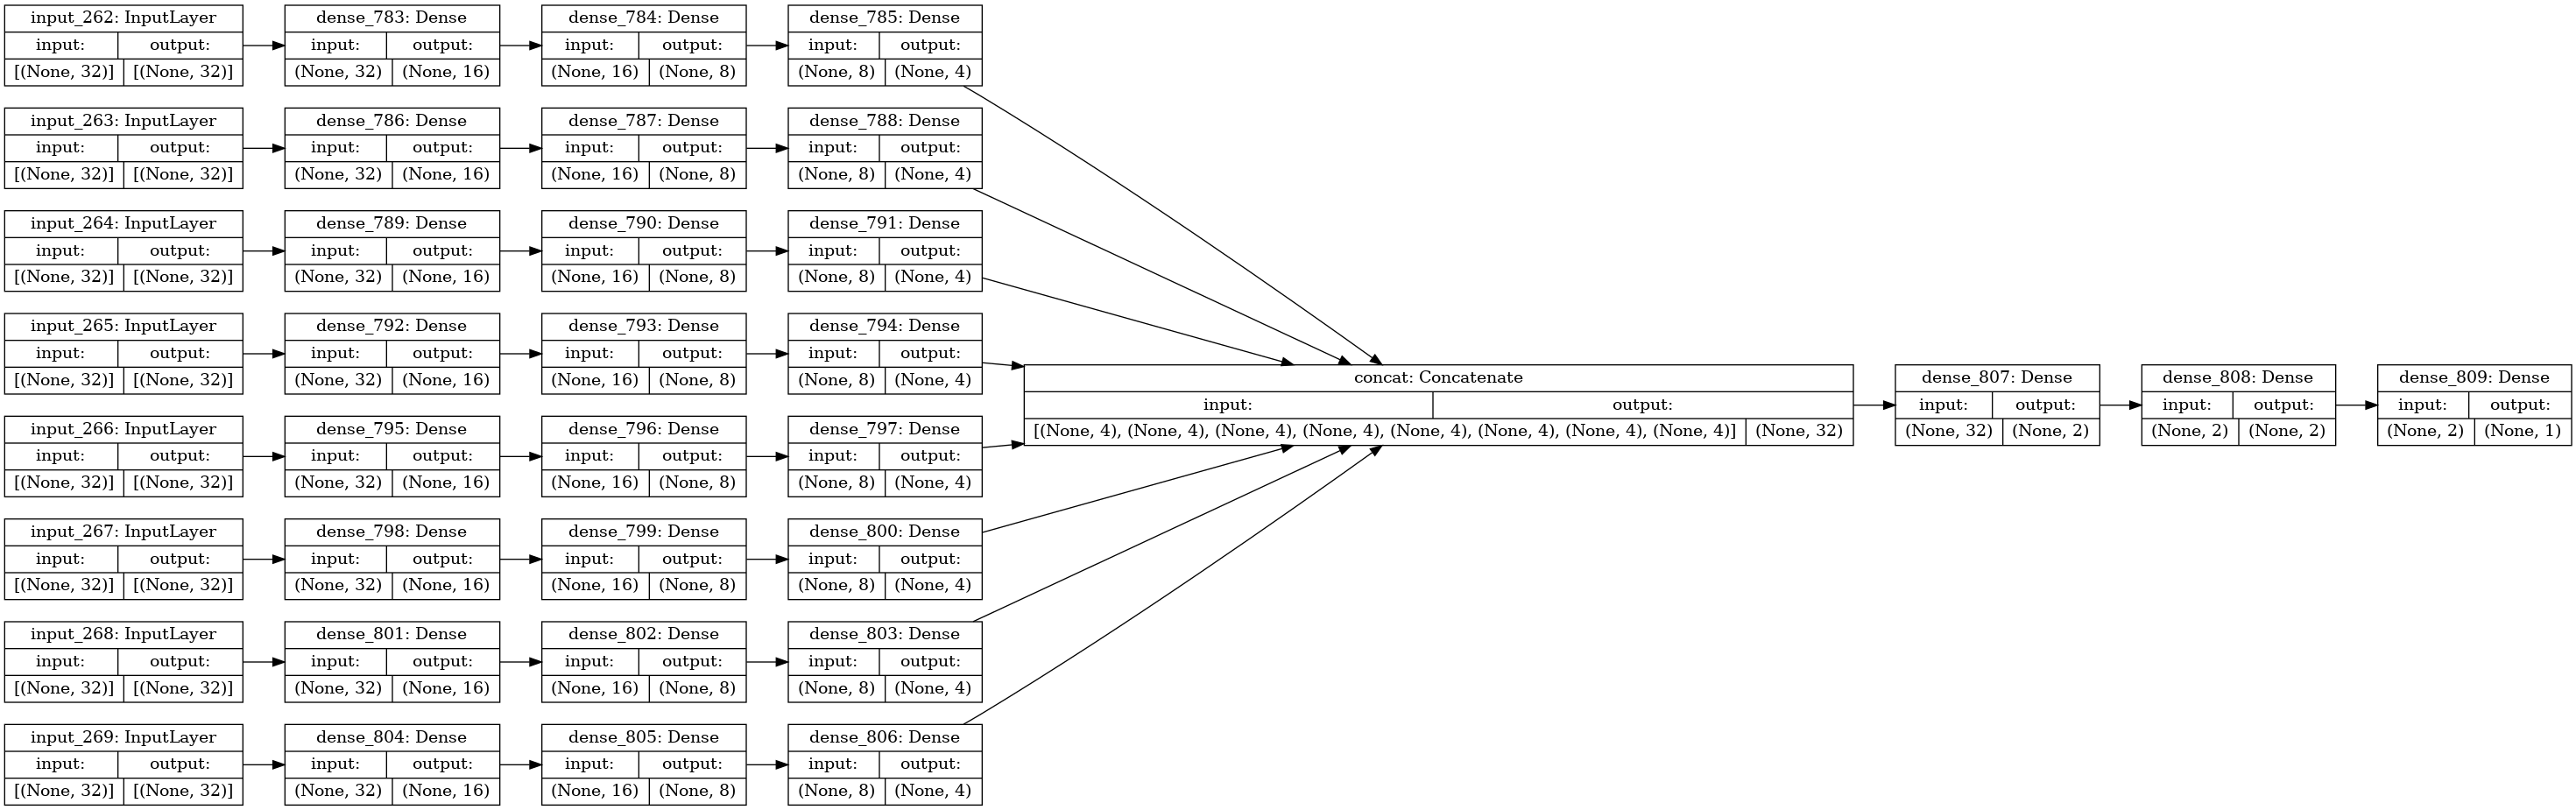

In [11]:
from tensorflow.keras.utils import plot_model, model_to_dot
plot_model(network.comb_net, "image.png", show_shapes=True, show_layer_names=True,rankdir='LR', dpi=96, expand_nested=True)

### Performance and removal of badly initialized networks.

In [12]:
print("Mean rmseiqr:", np.mean(rmseiqr), "sd rmseiqr:", np.std(rmseiqr))
print("Mean R2:", np.mean(r2), "sd R2:", np.std(r2))

Mean rmseiqr: 0.5855943739714269 sd rmseiqr: 0.7684575643537519
Mean R2: -0.45501668612496265 sd R2: 2.3078121277803616


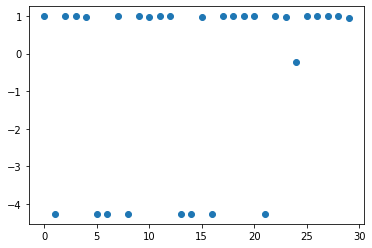

In [13]:
plt.scatter(x=range(n), y = r2)

In [14]:
outliers = np.where(np.array(r2)<0.9)[0]
outliers

array([ 1,  5,  6,  8, 13, 14, 16, 21, 24])

In [15]:
if len(outliers)>=1:
    rmseiqr = remove_outliers(rmseiqr, outliers)
    r2 = remove_outliers(r2, outliers)
    
    t = []
    for i in KO:
        t.append(i.tolist())

    KO = remove_outliers(t, outliers)

    t = []
    for i in KI:
        t.append(i.tolist())

    KI = remove_outliers(t, outliers)
    vargrad_max = remove_outliers(vargrad_max, outliers)
    vargrad_mean = remove_outliers(vargrad_mean, outliers)

In [16]:
print("Mean rmseiqr:", np.mean(rmseiqr), "sd rmseiqr:", np.std(rmseiqr))
print("Mean R2:", np.mean(r2), "sd R2:", np.std(r2))

Mean rmseiqr: 0.09436180866764984 sd rmseiqr: 0.024760997205283804
Mean R2: 0.9851649239619439 sd R2: 0.00917483622113662


### Results as histogram-swarm plots.

In [17]:
def violinplot_block_importance(measure, name, minimize,title_text=None):
    
    length = np.shape(np.vstack(measure))[0]

    dic = {"Block": list(np.repeat("Block1", length)) + list(np.repeat("Block2", length))
           + list(np.repeat("Block3", length))
                 + list(np.repeat("Block4", length))
                       + list(np.repeat("Block5", length))
                             + list(np.repeat("Block6", length))
                                   + list(np.repeat("Block7", length))
                                         + list(np.repeat("Block8", length)),
                                                    name : np.column_stack(np.vstack(measure)).reshape(-1,)}
    dic = pd.DataFrame(dic)

    fig, ax =plt.subplots(1,1)
    fig.set_size_inches(15, 10)
    sns.set(font_scale = 2)

    a = sns.boxplot(x="Block", y=name, data=dic, whis=np.inf, palette="Paired")
    sns.swarmplot(x="Block", y=name, data=dic, color=".2", size=6)
    a.set(xlabel=None)
    a.set(title=title_text)

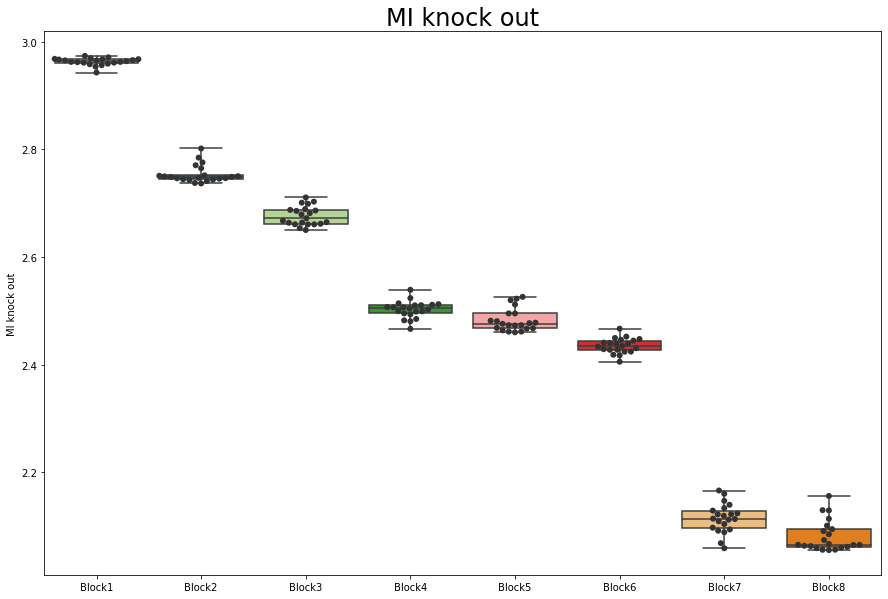

In [18]:
violinplot_block_importance(KO, "MI knock out", minimize=False, title_text = "MI knock out")

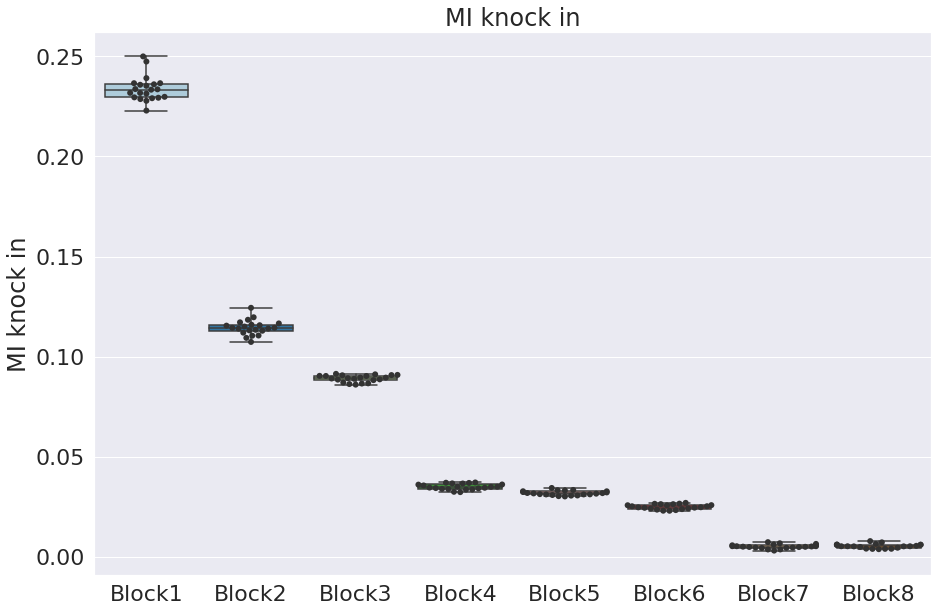

In [19]:
violinplot_block_importance(KI, "MI knock in", minimize=False, title_text = "MI knock in")

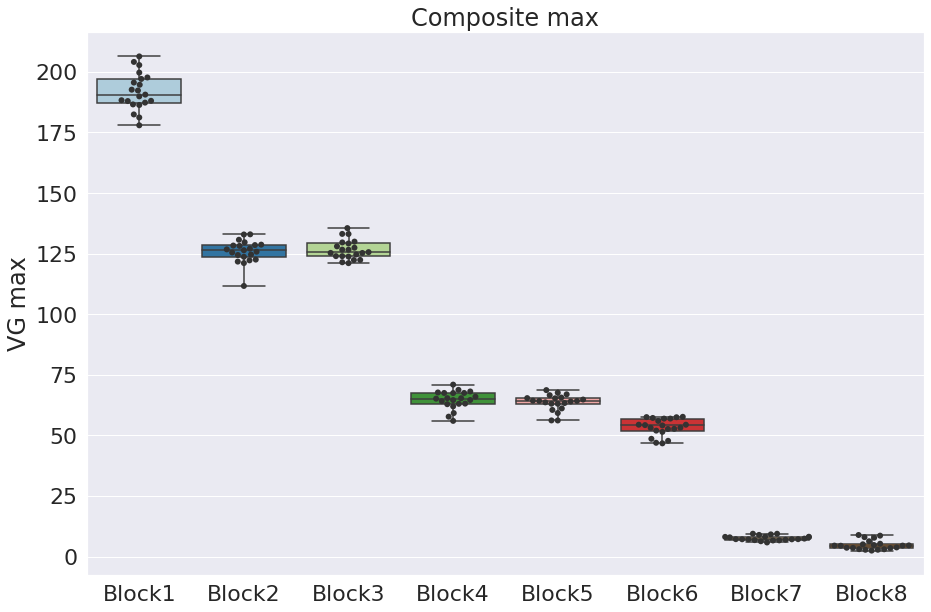

In [20]:
violinplot_block_importance(vargrad_max, "VG max", minimize=False, title_text = "Composite max")

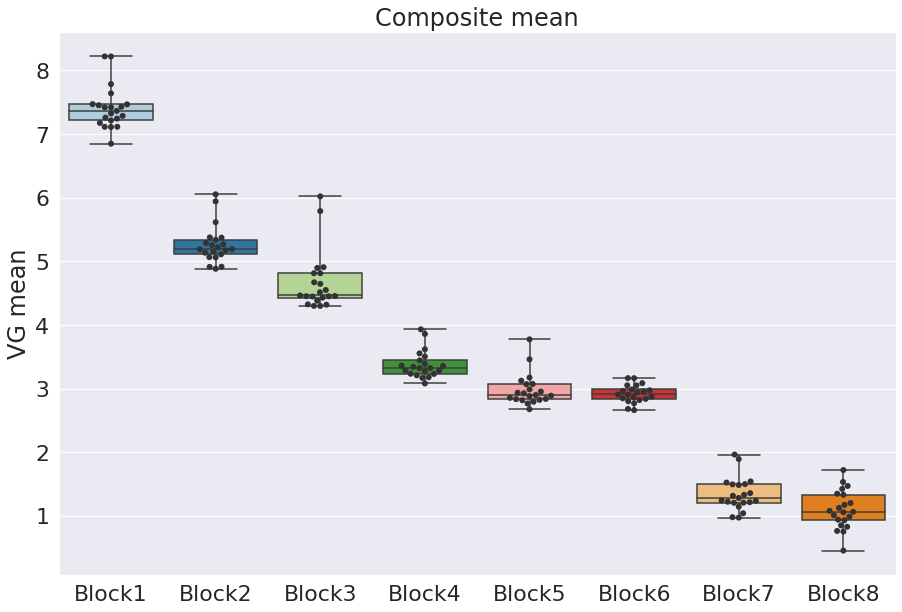

In [21]:
violinplot_block_importance(vargrad_mean, "VG mean", minimize=False, title_text = "Composite mean")